# Truss schematic 
<img src="./notbook-media/ex1.png" style="display:block;margin:auto;width:40%">

# Import Essential Libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from openseespy.opensees import *

# Problem Data

In [39]:
given_forces = [10, 10, 10]  # Forces in kips
stress_limit = 20  # kips/in^2
specific_weight = 0.284  # lb/in^3
length_truss = 40 * 12  # Convert feet to inches #!1
angles = np.arange(20, 81, 5)  # Angles from 80 to 5 degrees

# Fanctions

### calculate lengths
<img src="./notbook-media/ex1_calculate_lengths.png" style="display:block;margin:auto;width:40%">

In [40]:
# Function to calculate member lengths
def calculate_lengths(theta):
    theta_rad = np.radians(theta)
    L_Horizontal = 10 * 12 # feet to inch
    L_Vertical = np.tan(theta_rad) * L_Horizontal  # Length of BC in inches
    L_Diagonal = L_Vertical / np.sin(theta_rad)  # Length of AB in inches
    
    return L_Diagonal, L_Vertical, L_Horizontal

### calculate areas

In [41]:
# Function to calculate forces and cross-sectional areas
def calculate_areas(theta):
    L_Diagonal, L_Vertical, L_Horizontal= calculate_lengths(theta)
    # Assuming forces are proportional to lengths for simplicity
    force_Diagonal = given_forces[0] * (L_Diagonal / length_truss)
    force_Vertical = given_forces[1] * (L_Vertical / length_truss)
    force_Horizontal = given_forces[2] * (L_Horizontal / length_truss)

    
    # Areas = Force / Stress Limit
    area_Diagonal = force_Diagonal / stress_limit
    area_Vertical = force_Vertical / stress_limit
    area_Horizontal = force_Horizontal / stress_limit
    return area_Diagonal, area_Vertical, area_Horizontal, L_Diagonal, L_Vertical, L_Horizontal

### calculate weight

In [42]:
# Function to calculate weight of the truss
def calculate_weight(area_Diagonal, area_Vertical, area_Horizontal, L_Diagonal, L_Vertical, L_Horizontal):
    weight_Diagonal = area_Diagonal * L_Diagonal * specific_weight
    weight_Vertical = area_Vertical * L_Vertical * specific_weight
    weight_Horizontal = area_Horizontal * L_Horizontal * specific_weight
    total_weight = (weight_Diagonal * 4) + (weight_Vertical * 3) + (weight_Horizontal * 6)
    return total_weight

### analyze truss

In [43]:
# Function to build and analyze truss in OpenSeesPy
def analyze_truss(theta):
    wipe()

    # Node coordinates (in inches)
    theta_rad = np.radians(theta)
    _, L_Vertical,_ = calculate_lengths(theta)
    node_coords = {
        1: (0, 0),         # Node A
        2: (10 * 12, 0),   # Node C
        3: (20 * 12, 0),   # Node E
        4: (30 * 12, 0),   # Node G
        5: (40 * 12, 0),   # Node H
        6: (30 * 12, L_Vertical),  # Node F
        7: (20 * 12, L_Vertical), # Node D
        8: (10 * 12, L_Vertical), # Node B
    }

    # Create model
    model('basic', '-ndm', 2, '-ndf', 2)

    # Define nodes
    for node_id, coord in node_coords.items():
        node(node_id, *coord)

    # Define boundary conditions (supports)
    fix(1, 1, 1)  # Node F: Fixed support
    fix(5, 0, 1)  # Node H: Roller support

    # Define materials
    matTag = 1
    uniaxialMaterial('Elastic', matTag, 29000)  # Elastic modulus in ksi

    # Define elements (truss members)
    element_data = [
        (1, 1, 2),  # Member AC
        (2, 2, 3),  # Member CE
        (3, 3, 4),  # Member EG
        (4, 4, 5),  # Member GH
        (5, 5, 6),  # Member HF
        (6, 6, 4),  # Member FG
        (7, 6, 3),  # Member FE
        (8, 6, 7),  # Member FD
        (9, 7, 3),  # Member DE
        (10, 7,8),  # Member DB
        (11, 8, 3), # Member BE
        (12,8,2),   # Member BC
        (13,8,1)    # Member BF
    ]

    A_default = 1.0  # Default cross-sectional area in in^2
    for ele_id, i, j in element_data:
        element('Truss', ele_id, i, j, A_default, matTag)

    # Define loads
    timeSeries('Linear', 1)
    pattern('Plain', 1, 1)
    load(2, 0, -10)  # Load at Node C
    load(3, 0, -10)  # Load at Node E
    load(4, 0, -10)  # Load at Node G

    # Perform analysis
    system('BandSPD')
    numberer('Plain')
    constraints('Plain')
    integrator('LoadControl', 1.0)
    algorithm('Linear')
    analysis('Static')

    analyze(1)

    # Get reactions and member forces
    reactions = []
    for node_id in [1, 5]:
        rxn_x = nodeReaction(node_id, 1)
        rxn_y = nodeReaction(node_id, 2)
        reactions.append((rxn_x, rxn_y))

    member_forces = []
    for ele_id in range(1, len(element_data) + 1):
        force = eleForce(ele_id)
        member_forces.append(force)

    return reactions, member_forces

### Plot Truss

In [44]:
# Function to plot truss
def plot_truss(theta, member_forces):
    _, ax = plt.subplots()
    theta_rad = np.radians(theta)
    L_Diagonal, L_Vertical, L_Horizontal = calculate_lengths(theta)

    # Node coordinates (in inches)
    node_coords = {
        1: (0, 0),         # Node A
        2: (10 * 12, 0),   # Node C
        3: (20 * 12, 0),   # Node E
        4: (30 * 12, 0),   # Node G
        5: (40 * 12, 0),   # Node H
        6: (30 * 12, L_Vertical),  # Node F
        7: (20 * 12, L_Vertical), # Node D
        8: (10 * 12, L_Vertical), # Node B
    }

    # Truss members
    element_data = [
        (1, 2),  # AC
        (2, 3),  # CE
        (3, 4),  # EG
        (4, 5),  # GH
        (5, 6),  # HF
        (6, 4),  # FG
        (6, 3),  # FE
        (6, 7),  # FD
        (7, 3),  # DE
        (7, 8),  # DB
        (8, 3),  # BE
        (8, 2),  # BC
        (8, 1)   # BF
    ]

    # Plot nodes
    for coord in node_coords.values():
        ax.plot(coord[0], coord[1], 'bo')

    # Plot elements
    for (i, j), force in zip(element_data, member_forces):
        x = [node_coords[i][0], node_coords[j][0]]
        y = [node_coords[i][1], node_coords[j][1]]
        color = 'r' if force < 0 else 'g'  # Red for compression, green for tension
        ax.plot(x, y, color,'b')

    ax.set_aspect('equal', 'box')
    ax.set_title(f'Truss at Theta = {theta} degrees')
    plt.show()


TypeError: '<' not supported between instances of 'list' and 'int'

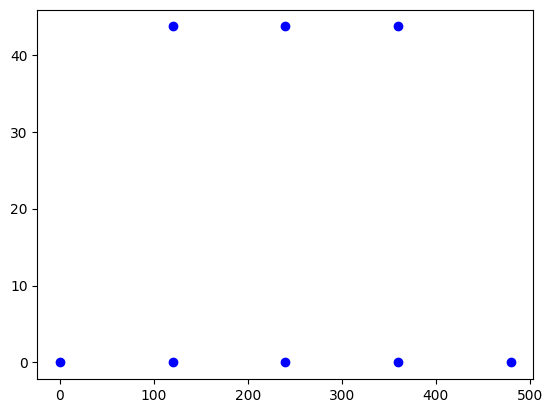

In [45]:
# Optimization loop
results = []
for theta in angles:
    area_Diagonal, area_Vertical, area_Horizontal, L_Diagonal, L_Vertical, L_Horizontal = calculate_areas(theta)
    weight = calculate_weight(area_Diagonal, area_Vertical, area_Horizontal, L_Diagonal, L_Vertical, L_Horizontal)
    reactions, member_forces = analyze_truss(theta)
    results.append((theta, weight, area_Diagonal, area_Vertical, member_forces))

    # Plot truss for the current angle
    plot_truss(theta, member_forces)

# Find the optimal angle
optimal_result = min(results, key=lambda x: x[1])
optimal_theta = optimal_result[0]
optimal_weight = optimal_result[1]

# Output results
print("Angle (Theta) | Weight (lb) | Area_AB (in^2) | Area_BC (in^2)")
for result in results:
    print(f"{result[0]:<14} | {result[1]:<11.2f} | {result[2]:<13.4f} | {result[3]:<13.4f}")

print("\nOptimal Angle:", optimal_theta, "degrees")
print("Minimum Weight:", optimal_weight, "lb")


# coordinates of Nodes and Members 


nodes = np.array([[0, 0], [10, 0], [20, 0], [30, 0], [40, 0], [30,20], [20, 20], [10,20]])
members = np.array([[1, 2],[2, 3],[5, 6],[6, 7],[1, 8],[2, 8],[3, 7],[3, 8],[4, 6],[3, 6],[7, 8],[3, 4],[4, 5]])

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,3,3])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for n in nodes:
    axes.plot([n[0]],[n[1]],'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()